# DINOv3 Spatial Feature Analysis for Glacier Images

This notebook analyzes DINOv3 features at the pixel level by:
1. Feeding the entire glacier-masked image to DINOv3
2. Extracting spatial features (14x14 grid) and mapping back to glacier pixels
3. Using UMAP to visualize features for each glacier pixel
4. Analyzing if features cluster by terrain type (water, ice, debris)

**Advantage**: No arbitrary patch boundaries - analyze the actual spatial context DINOv3 sees.

## Step 1: Setup and Imports

In [ ]:
# Core libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import rasterio
import geopandas as gpd
from rasterio.features import rasterize

# Deep learning
import torch
import torchvision.transforms as transforms
from transformers import AutoModel
from huggingface_hub import login

# Analysis tools
import umap
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from scipy import ndimage

# Login to HuggingFace
login(token="login-token")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

/Users/varyabazilova/opt/anaconda3/envs/superlakes/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


## Step 2: Load Data

In [2]:
# File paths
image_path = "/Users/varyabazilova/Desktop/glacial_lakes/super_lakes/dinov3_tryout/test_data/2021-09-04_fcc_testclip2.tif"
mask_path = "/Users/varyabazilova/Desktop/glacial_lakes/super_lakes/dinov3_tryout/test_data/lake_mask_testclip2.tif"
glacier_shp_path = "/Users/varyabazilova/Desktop/glacial_lakes/super_lakes/dinov3_tryout/test_data/clip_by_glacier.shp"

# Load satellite image and lake mask
with rasterio.open(image_path) as src:
    image = src.read()  # Shape: (channels, height, width)
    image = np.transpose(image, (1, 2, 0))  # Change to (height, width, channels)
    image_transform = src.transform
    image_crs = src.crs
    
with rasterio.open(mask_path) as src:
    lake_mask = src.read(1)  # Read first band

print(f"Image shape: {image.shape}")
print(f"Lake mask shape: {lake_mask.shape}")
print(f"Image CRS: {image_crs}")

# Convert to working formats
image_rgb = image[:,:,:3].astype(np.uint8)  # Take only RGB channels
lake_mask_binary = (lake_mask > 0).astype(np.float32)  # Binary lake mask

print(f"RGB image shape: {image_rgb.shape}")
print(f"RGB image range: {image_rgb.min()} - {image_rgb.max()}")

Image shape: (4673, 1362, 4)
Lake mask shape: (4673, 1362)
Image CRS: EPSG:32645
RGB image shape: (4673, 1362, 3)
RGB image range: 70 - 255


In [3]:
# Create glacier mask
def create_glacier_mask(glacier_shp_path, image_shape, image_transform, image_crs):
    """
    Create glacier mask from shapefile
    """
    # Load glacier shapefile
    glacier_gdf = gpd.read_file(glacier_shp_path)
    print(f"Loaded {len(glacier_gdf)} glacier polygons")
    
    # Reproject if needed
    if glacier_gdf.crs != image_crs:
        print(f"Reprojecting from {glacier_gdf.crs} to {image_crs}")
        glacier_gdf = glacier_gdf.to_crs(image_crs)
    
    # Create glacier mask
    glacier_mask = rasterize(
        [(geom, 1) for geom in glacier_gdf.geometry],
        out_shape=image_shape[:2],
        transform=image_transform,
        fill=0,
        dtype=np.uint8
    )
    
    glacier_pixels = glacier_mask.sum()
    total_pixels = glacier_mask.size
    glacier_coverage = glacier_pixels / total_pixels * 100
    
    print(f"Glacier mask: {glacier_pixels:,} pixels ({glacier_coverage:.1f}% of image)")
    
    return glacier_mask.astype(bool)

# Create glacier mask
glacier_mask = create_glacier_mask(glacier_shp_path, image.shape, image_transform, image_crs)
print(f"Glacier mask shape: {glacier_mask.shape}")
print(f"Lake pixels within glacier: {(glacier_mask & (lake_mask_binary > 0)).sum():,}")

Loaded 1 glacier polygons
Reprojecting from EPSG:4326 to EPSG:32645
Glacier mask: 1,409,146 pixels (22.1% of image)
Glacier mask shape: (4673, 1362)
Lake pixels within glacier: 29,633


## Step 3: Visualize Input Data

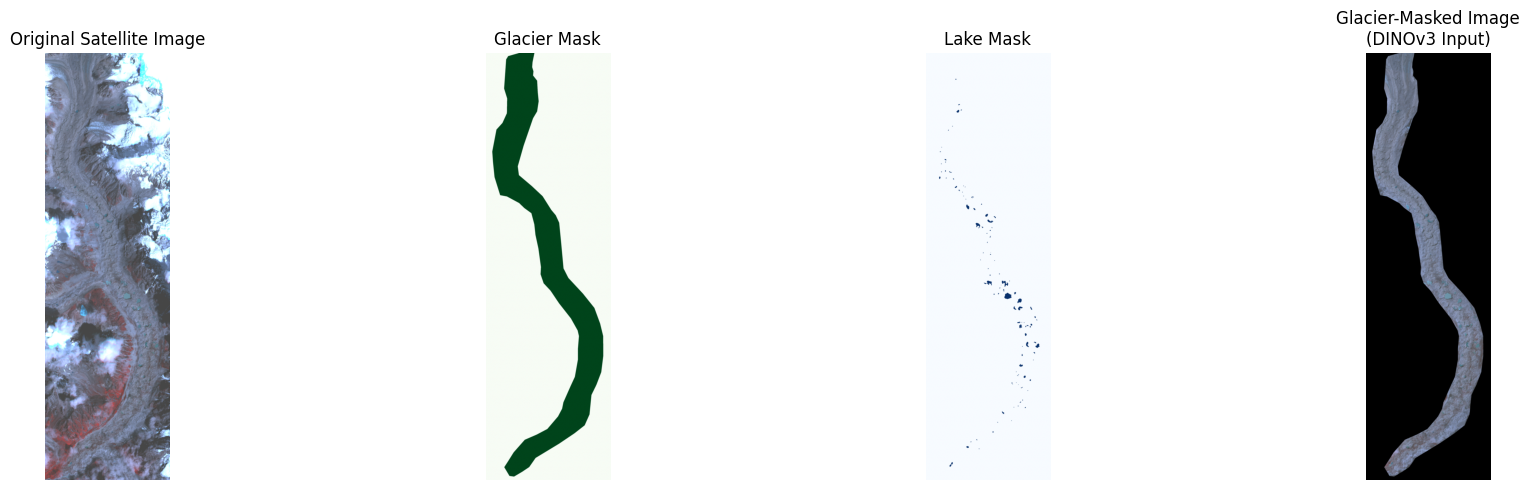

Analysis will focus on 1,409,146 glacier pixels
Of which 29,633 are lakes


In [4]:
# Visualize the data we'll analyze
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Original image
axes[0].imshow(image_rgb)
axes[0].set_title('Original Satellite Image')
axes[0].axis('off')

# Glacier mask
axes[1].imshow(glacier_mask, cmap='Greens')
axes[1].set_title('Glacier Mask')
axes[1].axis('off')

# Lake mask
axes[2].imshow(lake_mask_binary, cmap='Blues')
axes[2].set_title('Lake Mask')
axes[2].axis('off')

# Glacier-masked image (what DINOv3 will see)
masked_image = image_rgb.copy()
masked_image[~glacier_mask] = 0  # Set non-glacier pixels to black
axes[3].imshow(masked_image)
axes[3].set_title('Glacier-Masked Image\n(DINOv3 Input)')
axes[3].axis('off')

plt.tight_layout()
plt.show()

print(f"Analysis will focus on {glacier_mask.sum():,} glacier pixels")
print(f"Of which {(glacier_mask & (lake_mask_binary > 0)).sum():,} are lakes")

## Step 4: Load DINOv3 Model and Extract Spatial Features

In [5]:
# Load DINOv3 model for feature extraction
print("Loading DINOv3 model...")
dinov3_model = AutoModel.from_pretrained("facebook/dinov3-vitb16-pretrain-lvd1689m")
dinov3_model.eval()
dinov3_model = dinov3_model.to(device)

# Transform for DINOv3 input (resize to 224x224)
dinov3_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("DINOv3 model loaded successfully!")

Loading DINOv3 model...
DINOv3 model loaded successfully!


In [6]:
def extract_spatial_features(image, glacier_mask, model, transform, device):
    """
    Extract DINOv3 features for the entire image and map to glacier pixels
    """
    print("Extracting spatial DINOv3 features...")
    
    # Create glacier-masked image (set non-glacier to black)
    masked_image = image.copy()
    masked_image[~glacier_mask] = 0
    
    # Transform entire image to 224x224 for DINOv3
    image_tensor = transform(masked_image).unsqueeze(0).to(device)
    
    # Extract DINOv3 features
    with torch.no_grad():
        features = model(image_tensor).last_hidden_state
        
        # Remove CLS token and get spatial features
        patch_features = features[0, 1:]  # Shape: (196, 768) for 14x14 patches
        
        # Reshape to spatial grid
        num_patches = int(np.sqrt(patch_features.shape[0]))
        spatial_features = patch_features.reshape(num_patches, num_patches, 768)
        
        print(f"DINOv3 spatial features: {spatial_features.shape} (patches × patches × features)")
    
    # Map features back to original image coordinates
    height, width = glacier_mask.shape
    feature_map = np.zeros((height, width, 768))
    
    print(f"Mapping {num_patches}×{num_patches} patches to {height}×{width} image...")
    
    # Each patch corresponds to a region in the original image
    for i in range(num_patches):
        for j in range(num_patches):
            # Calculate corresponding region in original image
            y_start = int(i * height / num_patches)
            y_end = int((i + 1) * height / num_patches)
            x_start = int(j * width / num_patches)
            x_end = int((j + 1) * width / num_patches)
            
            # Assign DINOv3 feature to all pixels in this region
            feature_vector = spatial_features[i, j].cpu().numpy()
            feature_map[y_start:y_end, x_start:x_end] = feature_vector
    
    # Extract features only for glacier pixels
    glacier_features = feature_map[glacier_mask]  # Shape: (n_glacier_pixels, 768)
    glacier_coordinates = np.where(glacier_mask)
    
    print(f"Extracted features for {glacier_features.shape[0]:,} glacier pixels")
    print(f"Feature dimensionality: {glacier_features.shape[1]}")
    
    return glacier_features, glacier_coordinates, feature_map

# Extract spatial features
glacier_features, glacier_coords, full_feature_map = extract_spatial_features(
    image_rgb, glacier_mask, dinov3_model, dinov3_transform, device
)

Extracting spatial DINOv3 features...


RuntimeError: shape '[14, 14, 768]' is invalid for input of size 153600

## Step 5: Create Pixel-Level Labels

In [8]:
def create_pixel_labels(lake_mask, glacier_mask, glacier_coords):
    """
    Create terrain labels for each glacier pixel
    """
    # Extract labels for glacier pixels only
    glacier_lake_mask = lake_mask[glacier_coords]
    
    # Create detailed terrain labels
    labels = []
    
    for i, (y, x) in enumerate(zip(glacier_coords[0], glacier_coords[1])):
        # Check if this pixel is lake
        if glacier_lake_mask[i] > 0:
            labels.append('lake')
        else:
            # For non-lake pixels, analyze local neighborhood to classify ice type
            # Extract 5x5 neighborhood
            y_start = max(0, y-2)
            y_end = min(lake_mask.shape[0], y+3)
            x_start = max(0, x-2) 
            x_end = min(lake_mask.shape[1], x+3)
            
            local_glacier = glacier_mask[y_start:y_end, x_start:x_end]
            local_lake = lake_mask[y_start:y_end, x_start:x_end]
            
            # Classify based on local context
            if local_lake.sum() > 0:  # Near lakes
                labels.append('near_lake')
            elif local_glacier.mean() > 0.8:  # Pure glacier area
                labels.append('clean_ice')
            else:  # Mixed or edge areas
                labels.append('mixed_ice')
    
    print("Pixel-level terrain classification:")
    label_counts = pd.Series(labels).value_counts()
    for label, count in label_counts.items():
        print(f"  {label}: {count:,} pixels ({count/len(labels)*100:.1f}%)")
    
    return labels

# Create pixel-level labels
pixel_labels = create_pixel_labels(lake_mask_binary, glacier_mask, glacier_coords)

NameError: name 'glacier_coords' is not defined

## Step 6: Sample for UMAP Analysis

In [9]:
# Sample pixels for UMAP (too many pixels for efficient computation)
def sample_pixels_for_analysis(features, labels, coords, max_samples=5000):
    """
    Sample a subset of pixels for UMAP analysis, ensuring balanced representation
    """
    n_pixels = len(labels)
    
    if n_pixels <= max_samples:
        print(f"Using all {n_pixels:,} pixels for analysis")
        return features, labels, coords
    
    print(f"Sampling {max_samples:,} pixels from {n_pixels:,} total glacier pixels")
    
    # Stratified sampling to ensure balanced representation
    unique_labels = list(set(labels))
    samples_per_label = max_samples // len(unique_labels)
    
    sampled_indices = []
    
    for label in unique_labels:
        label_indices = [i for i, l in enumerate(labels) if l == label]
        n_available = len(label_indices)
        n_sample = min(samples_per_label, n_available)
        
        # Random sample
        if n_sample < n_available:
            sampled = np.random.choice(label_indices, n_sample, replace=False)
        else:
            sampled = label_indices
        
        sampled_indices.extend(sampled)
        print(f"  {label}: sampled {len(sampled):,} / {n_available:,} pixels")
    
    # Extract sampled data
    sampled_indices = np.array(sampled_indices)
    sampled_features = features[sampled_indices]
    sampled_labels = [labels[i] for i in sampled_indices]
    sampled_coords = (coords[0][sampled_indices], coords[1][sampled_indices])
    
    print(f"Final sample: {len(sampled_labels):,} pixels")
    
    return sampled_features, sampled_labels, sampled_coords

# Sample pixels for analysis
np.random.seed(42)  # For reproducibility
sample_features, sample_labels, sample_coords = sample_pixels_for_analysis(
    glacier_features, pixel_labels, glacier_coords, max_samples=5000
)

NameError: name 'glacier_features' is not defined

## Step 7: UMAP Analysis

In [10]:
# Apply UMAP to visualize high-dimensional DINOv3 features
print("Applying UMAP dimensionality reduction to DINOv3 features...")

umap_reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric='cosine',
    random_state=42,
    verbose=True
)

# Fit UMAP
umap_embedding = umap_reducer.fit_transform(sample_features)

print(f"UMAP embedding shape: {umap_embedding.shape}")
print(f"UMAP range: X=[{umap_embedding[:,0].min():.2f}, {umap_embedding[:,0].max():.2f}], Y=[{umap_embedding[:,1].min():.2f}, {umap_embedding[:,1].max():.2f}]")

Applying UMAP dimensionality reduction to DINOv3 features...


NameError: name 'sample_features' is not defined

## Step 8: Visualize Feature Space

In [ ]:
# Create comprehensive visualization of feature space
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Plot 1: Colored by terrain type
unique_labels = list(set(sample_labels))
colors = plt.cm.Set1(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    mask = np.array(sample_labels) == label
    axes[0,0].scatter(umap_embedding[mask, 0], umap_embedding[mask, 1], 
                     c=[color], label=label, alpha=0.7, s=20)

axes[0,0].set_xlabel('UMAP Dimension 1')
axes[0,0].set_ylabel('UMAP Dimension 2')
axes[0,0].set_title('DINOv3 Features by Terrain Type')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Lake vs Non-Lake (binary)
binary_labels = ['Lake' if label == 'lake' else 'Non-Lake' for label in sample_labels]
lake_mask = np.array(binary_labels) == 'Lake'

axes[0,1].scatter(umap_embedding[~lake_mask, 0], umap_embedding[~lake_mask, 1], 
                 c='lightgray', alpha=0.5, s=15, label='Non-Lake')
axes[0,1].scatter(umap_embedding[lake_mask, 0], umap_embedding[lake_mask, 1], 
                 c='blue', alpha=0.8, s=25, label='Lake')
axes[0,1].set_xlabel('UMAP Dimension 1')
axes[0,1].set_ylabel('UMAP Dimension 2')
axes[0,1].set_title('Lake vs Non-Lake Separation')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Density plot
axes[0,2].hexbin(umap_embedding[:, 0], umap_embedding[:, 1], gridsize=30, cmap='Blues')
axes[0,2].set_xlabel('UMAP Dimension 1')
axes[0,2].set_ylabel('UMAP Dimension 2')
axes[0,2].set_title('Feature Density')

# Plot 4: Spatial distribution of sampled pixels
# Create a spatial plot showing where sampled pixels are located
spatial_image = np.zeros_like(glacier_mask, dtype=float)
for i, label in enumerate(sample_labels):
    y, x = sample_coords[0][i], sample_coords[1][i]
    if label == 'lake':
        spatial_image[y, x] = 1.0  # Blue for lakes
    elif label == 'near_lake':
        spatial_image[y, x] = 0.7  # Light blue for near lakes
    elif label == 'clean_ice':
        spatial_image[y, x] = 0.3  # Light gray for clean ice
    else:
        spatial_image[y, x] = 0.5  # Gray for mixed

axes[1,0].imshow(spatial_image, cmap='viridis')
axes[1,0].set_title('Spatial Distribution of Sampled Pixels')
axes[1,0].axis('off')

# Plot 5: Feature variance by terrain type
terrain_types = unique_labels
feature_vars = []
for terrain in terrain_types:
    mask = np.array(sample_labels) == terrain
    if mask.sum() > 1:
        terrain_features = sample_features[mask]
        feature_var = np.var(terrain_features, axis=0).mean()
        feature_vars.append(feature_var)
    else:
        feature_vars.append(0)

axes[1,1].bar(terrain_types, feature_vars)
axes[1,1].set_title('Feature Variance by Terrain Type')
axes[1,1].set_ylabel('Mean Feature Variance')
axes[1,1].tick_params(axis='x', rotation=45)

# Plot 6: Class distribution
label_counts = pd.Series(sample_labels).value_counts()
axes[1,2].pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%')
axes[1,2].set_title('Sample Distribution by Terrain Type')

plt.tight_layout()
plt.show()

## Step 9: Quantitative Analysis

In [ ]:
# Quantitative analysis of feature clustering
print("=== Quantitative Feature Analysis ===")
print()

# Encode labels for metrics
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(sample_labels)

# Silhouette scores
silhouette_original = silhouette_score(sample_features, encoded_labels)
silhouette_umap = silhouette_score(umap_embedding, encoded_labels)

print(f"1. Clustering Quality:")
print(f"   Silhouette Score (DINOv3 features): {silhouette_original:.3f}")
print(f"   Silhouette Score (UMAP embedding): {silhouette_umap:.3f}")
print()

# Lake separability analysis
def analyze_lake_separability(features, labels):
    """
    Analyze how well lake features separate from non-lake features
    """
    lake_indices = [i for i, label in enumerate(labels) if label == 'lake']
    non_lake_indices = [i for i, label in enumerate(labels) if label != 'lake']
    
    if len(lake_indices) > 0 and len(non_lake_indices) > 0:
        from sklearn.metrics.pairwise import euclidean_distances
        
        lake_features = features[lake_indices]
        non_lake_features = features[non_lake_indices]
        
        # Calculate distances
        if len(lake_indices) > 1:
            lake_distances = euclidean_distances(lake_features)
            avg_within_lake = lake_distances[np.triu_indices_from(lake_distances, k=1)].mean()
        else:
            avg_within_lake = 0
            
        if len(non_lake_indices) > 1:
            non_lake_distances = euclidean_distances(non_lake_features)
            avg_within_non_lake = non_lake_distances[np.triu_indices_from(non_lake_distances, k=1)].mean()
        else:
            avg_within_non_lake = 0
        
        between_distances = euclidean_distances(lake_features, non_lake_features)
        avg_between = between_distances.mean()
        
        return avg_within_lake, avg_within_non_lake, avg_between
    
    return None, None, None

within_lake, within_non_lake, between_groups = analyze_lake_separability(sample_features, sample_labels)

if within_lake is not None:
    print(f"2. Lake Separability Analysis:")
    print(f"   Average within-lake distance: {within_lake:.3f}")
    print(f"   Average within-non-lake distance: {within_non_lake:.3f}")
    print(f"   Average between-group distance: {between_groups:.3f}")
    
    if within_lake > 0 and within_non_lake > 0:
        separability = between_groups / ((within_lake + within_non_lake) / 2)
        print(f"   Separability ratio: {separability:.3f} (higher = better separation)")
    print()

# K-means clustering evaluation
n_clusters = len(unique_labels)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(umap_embedding)
ari_score = adjusted_rand_score(encoded_labels, cluster_labels)

print(f"3. Unsupervised Clustering:")
print(f"   K-means clusters: {n_clusters}")
print(f"   Adjusted Rand Index: {ari_score:.3f}")
print()

# Feature statistics
print(f"4. Dataset Statistics:")
print(f"   Total glacier pixels: {len(glacier_features):,}")
print(f"   Sampled for analysis: {len(sample_features):,}")
print(f"   Feature dimensionality: {sample_features.shape[1]}")
lake_count = sum(1 for label in sample_labels if label == 'lake')
print(f"   Lake pixels in sample: {lake_count:,} ({lake_count/len(sample_labels)*100:.1f}%)")
print()

## Step 10: Feature Quality Assessment

In [ ]:
# Comprehensive assessment of DINOv3 feature quality for lake detection
print("=== DINOv3 Feature Quality Assessment for Lake Detection ===")
print()

# Define quality thresholds
good_silhouette = 0.3
good_separability = 1.5
good_ari = 0.3

# Overall assessment
quality_score = 0
max_score = 3

print("Quality Metrics:")
if silhouette_original >= good_silhouette:
    print(f"   ✅ Silhouette Score: {silhouette_original:.3f} (>= {good_silhouette}) - Good clustering")
    quality_score += 1
else:
    print(f"   ⚠️  Silhouette Score: {silhouette_original:.3f} (< {good_silhouette}) - Weak clustering")

if 'separability' in locals() and separability >= good_separability:
    print(f"   ✅ Separability Ratio: {separability:.3f} (>= {good_separability}) - Good lake separation")
    quality_score += 1
elif 'separability' in locals():
    print(f"   ⚠️  Separability Ratio: {separability:.3f} (< {good_separability}) - Moderate lake separation")
else:
    print(f"   ❌ Separability: Cannot calculate (insufficient lake samples)")

if ari_score >= good_ari:
    print(f"   ✅ Adjusted Rand Index: {ari_score:.3f} (>= {good_ari}) - Good unsupervised clustering")
    quality_score += 1
else:
    print(f"   ⚠️  Adjusted Rand Index: {ari_score:.3f} (< {good_ari}) - Weak unsupervised clustering")

print()
print(f"Overall Quality Score: {quality_score}/{max_score}")
print()

# Recommendations
print("Recommendations:")
if quality_score >= 2:
    print("   💡 DINOv3 features show promise for lake detection")
    print("   💡 Consider training segmentation model with these features")
    print("   💡 May work well with supervised learning approach")
elif quality_score == 1:
    print("   💡 DINOv3 features show moderate quality")
    print("   💡 Recommend hybrid approach: NDWI + DINOv3 refinement")
    print("   💡 Use DINOv3 to reduce NDWI false positives")
else:
    print("   💡 DINOv3 features alone may not be sufficient")
    print("   💡 Stick with NDWI-based detection")
    print("   💡 Consider alternative feature extraction methods")

if lake_count < 100:
    print(f"   ⚠️  Limited lake samples ({lake_count}) - consider larger training dataset")

if quality_score >= 1:
    print("   💡 Spatial feature approach is working - features vary meaningfully across terrain")
else:
    print("   ⚠️  May need different feature extraction strategy")

print()
print("Next Steps:")
if quality_score >= 2:
    print("   1. Proceed with supervised training using DINOv3 features")
    print("   2. Experiment with different patch sizes for training")
    print("   3. Compare with NDWI baseline")
else:
    print("   1. Implement NDWI + DINOv3 hybrid approach")
    print("   2. Use NDWI for primary detection, DINOv3 for refinement")
    print("   3. Focus on reducing false positives rather than primary detection")

## Step 11: Save Results

In [ ]:
# Save analysis results for future use
import pickle

# Prepare results dictionary
results = {
    'sample_features': sample_features,
    'umap_embedding': umap_embedding,
    'sample_labels': sample_labels,
    'sample_coords': sample_coords,
    'silhouette_original': silhouette_original,
    'silhouette_umap': silhouette_umap,
    'ari_score': ari_score,
    'quality_score': quality_score,
    'total_glacier_pixels': len(glacier_features),
    'lake_pixel_count': lake_count
}

if 'separability' in locals():
    results['separability_ratio'] = separability
    results['within_lake_distance'] = within_lake
    results['within_non_lake_distance'] = within_non_lake
    results['between_groups_distance'] = between_groups

# Save results
results_path = '/Users/varyabazilova/Desktop/glacial_lakes/super_lakes/dinov3_tryout/test_code/spatial_feature_analysis_results.pkl'
with open(results_path, 'wb') as f:
    pickle.dump(results, f)

print(f"Analysis results saved to: {results_path}")

# Save UMAP coordinates as CSV for external analysis
df_results = pd.DataFrame({
    'umap_x': umap_embedding[:, 0],
    'umap_y': umap_embedding[:, 1],
    'terrain_type': sample_labels,
    'pixel_y': sample_coords[0],
    'pixel_x': sample_coords[1],
    'is_lake': [label == 'lake' for label in sample_labels]
})

csv_path = '/Users/varyabazilova/Desktop/glacial_lakes/super_lakes/dinov3_tryout/test_code/spatial_umap_results.csv'
df_results.to_csv(csv_path, index=False)
print(f"UMAP results saved to: {csv_path}")

print()
print("=== Analysis Complete! ===")
print(f"Quality Score: {quality_score}/{max_score}")
if quality_score >= 2:
    print("✅ DINOv3 features suitable for lake detection training")
else:
    print("💡 Consider hybrid NDWI + DINOv3 approach")